In [111]:
import pandas as pd
from editdistance import eval as ed
import numpy as np
from address_compare.tagging import AddressTagger
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
%pylab inline
import re
from sklearn import naive_bayes

ADDRESS_COLS = ["STREET_NUMBER", "PRE_DIRECTION", "STREET_NAME", "STREET_TYPE", "POST_DIRECTION",
                "UNIT_TYPE", "UNIT_NUMBER"]
DIST_COLS = ["STREET_NAME", "STREET_TYPE", "UNIT_NUMBER"]
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def digit_extract(s):
    re_digit_extract = re.compile('(^\d+$|\d+(?=st|nd|rd|th|ST|ND|RD|TH))')
    d = re_digit_extract.search(s)
    return d.group() if d is not None else ''

def series_ed(s1: pd.Series, s2: pd.Series):
    '''
    vectorizes edit distance over two pandas series
    :param s1: series of strings
    :param s2: series of strings
    :return: series of numbers
    '''
    df = pd.concat([s1, s2], axis=1)
    df.columns = ['a', 'b']
    return pd.concat([s1, s2], axis=1).apply(lambda x: ed(x[0], x[1]), axis=1, raw = True)

def edit_distance_matrix(df1: pd.DataFrame, df2: pd.DataFrame):
    out = pd.DataFrame()
    for col in DIST_COLS:
        out[col+'DIST'] = series_ed(df1[col], df2[col])
    return out

def equal_features(df1: pd.DataFrame, df2: pd.DataFrame):
    out = pd.DataFrame()
    for col in ADDRESS_COLS:
        out[col+'_EQUAL'] = df1[col] == df2[col]
    return out

def number_mod_text(s1, s2):
    if (s1 == s2):
        return True
    d1 = digit_extract(s1)
    if d1:
        d2 = digit_extract(s2)
        return d1 == d2
    return False

def number_mod_text_series(s1, s2):
    return pd.concat([s1, s2], 1).apply(lambda x: number_mod_text(x[0], x[1]), 1, raw = True)

Populating the interactive namespace from numpy and matplotlib


C:\Users\colin\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [112]:
from statsmodels.api import Logit
at = AddressTagger()

In [113]:
from address_compare.address_randomizer import random_addresses2
full_data = random_addresses2(50)
full_data

,address_1,address_2,match
0,"#C, 39059 MAPLE BLVD E",APT C - 39059 MAPLE BLVD E,True
1,"#C, 39059 MAPLE BLVD E",APT C-39059 MAPLE BLVD E,True
2,"#C, 39059 MAPLE BLVD E","APT C, 39059 MAPLE BLVD E",True
3,"#C, 39059 MAPLE BLVD E","39059 MAPLE BLVD E, APT C",True
4,"#C, 39059 MAPLE BLVD E",C - 39059 MAPLE BLVD E,True
5,APT C - 39059 MAPLE BLVD E,APT C-39059 MAPLE BLVD E,True
6,APT C - 39059 MAPLE BLVD E,"APT C, 39059 MAPLE BLVD E",True
7,APT C - 39059 MAPLE BLVD E,"39059 MAPLE BLVD E, APT C",True
8,APT C - 39059 MAPLE BLVD E,C - 39059 MAPLE BLVD E,True
9,APT C-39059 MAPLE BLVD E,"APT C, 39059 MAPLE BLVD E",True


In [114]:
ad1 = at.series_to_address_df(full_data['address_1'], standardize=True)
ad2 = at.series_to_address_df(full_data['address_2'], standardize=True)
features = pd.concat([edit_distance_matrix(ad1, ad2), equal_features(ad1, ad2)], axis = 1)
features['STREET_MOD_TEXT_EQUAL'] = number_mod_text_series(ad1['STREET_NAME'], ad2['STREET_NAME'])
features['const'] = 1
features = features.applymap(int)
train = np.random.binomial(1, .7, full_data.shape[0]) == 1
features.corr()

,STREET_NAMEDIST,STREET_TYPEDIST,UNIT_NUMBERDIST,STREET_NUMBER_EQUAL,PRE_DIRECTION_EQUAL,STREET_NAME_EQUAL,STREET_TYPE_EQUAL,POST_DIRECTION_EQUAL,UNIT_TYPE_EQUAL,UNIT_NUMBER_EQUAL,STREET_MOD_TEXT_EQUAL,const
STREET_NAMEDIST,1.000,0.374,0.297,-0.391,-0.256,-0.640,-0.398,-0.306,-0.108,-0.270,-0.686,nan
STREET_TYPEDIST,0.374,1.000,0.239,-0.282,-0.472,-0.303,-0.943,-0.483,-0.204,-0.155,-0.457,nan
UNIT_NUMBERDIST,0.297,0.239,1.000,-0.734,-0.187,-0.402,-0.203,-0.207,-0.036,-0.655,-0.486,nan
STREET_NUMBER_EQUAL,-0.391,-0.282,-0.734,1.000,0.250,0.407,0.284,0.236,-0.019,0.567,0.543,nan
PRE_DIRECTION_EQUAL,-0.256,-0.472,-0.187,0.250,1.000,0.243,0.484,0.558,0.136,0.143,0.382,nan
STREET_NAME_EQUAL,-0.640,-0.303,-0.402,0.407,0.243,1.000,0.307,0.242,0.069,0.292,0.726,nan
STREET_TYPE_EQUAL,-0.398,-0.943,-0.203,0.284,0.484,0.307,1.000,0.458,0.208,0.166,0.470,nan
POST_DIRECTION_EQUAL,-0.306,-0.483,-0.207,0.236,0.558,0.242,0.458,1.000,0.098,0.137,0.379,nan
UNIT_TYPE_EQUAL,-0.108,-0.204,-0.036,-0.019,0.136,0.069,0.208,0.098,1.000,0.217,0.111,nan
UNIT_NUMBER_EQUAL,-0.270,-0.155,-0.655,0.567,0.143,0.292,0.166,0.137,0.217,1.000,0.379,nan


In [116]:
f = Logit(full_data[train]['match'], features[train])
f = f.fit()

Optimization terminated successfully.
         Current function value: 0.443818
         Iterations 8


In [117]:
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  match   No. Observations:                 1237
Model:                          Logit   Df Residuals:                     1225
Method:                           MLE   Df Model:                           11
Date:                Mon, 18 Dec 2017   Pseudo R-squ.:                  0.3239
Time:                        22:39:10   Log-Likelihood:                -549.00
converged:                       True   LL-Null:                       -812.04
                                        LLR p-value:                8.744e-106
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
STREET_NAMEDIST          -0.2253      0.055     -4.109      0.000      -0.333      -0.118
STREET_TYPEDIST           0.3798      0.171      2.219      0.026       0.044       0.715
UNIT_NUMBERDIST           0.5402      0.056      9.582      0.000       0.430       0.651
STREET_NUMBER_EQUAL       1.7371      0.231      7.534      0.000       1.285       2.189
PRE_DIRECTION_EQUAL       1.0196      0.346      2.951      0.003       0.342       1.697
STREET_NAME_EQUAL        -0.9858      0.269     -3.662      0.000      -1.513      -0.458
STREET_TYPE_EQUAL         5.2133      1.097      4.752      0.000       3.063       7.363
POST_DIRECTION_EQUAL      0.9970      0.349      2.854      0.004       0.312       1.682
UNIT_TYPE_EQUAL          -0.4170      0.165     -2.525      0.012      -0.741      -0.093
UNIT_NUMBER_EQUAL         1.2643      0.231      5.467      0.000       0.811       1.718
STREET_MOD_TEXT_EQUAL     0.7529      0.326      2.308      0.021       0.113       1.392
const                    -8.1049      1.226     -6.613      0.000     -10.507      -5.703
=========================================================================================
"""

In [119]:
full_data['prob'] = f.predict(features)

In [120]:
full_data

,address_1,address_2,match,prob
0,"#C, 39059 MAPLE BLVD E",APT C - 39059 MAPLE BLVD E,True,0.869
1,"#C, 39059 MAPLE BLVD E",APT C-39059 MAPLE BLVD E,True,0.734
2,"#C, 39059 MAPLE BLVD E","APT C, 39059 MAPLE BLVD E",True,0.869
3,"#C, 39059 MAPLE BLVD E","39059 MAPLE BLVD E, APT C",True,0.869
4,"#C, 39059 MAPLE BLVD E",C - 39059 MAPLE BLVD E,True,0.763
5,APT C - 39059 MAPLE BLVD E,APT C-39059 MAPLE BLVD E,True,0.645
6,APT C - 39059 MAPLE BLVD E,"APT C, 39059 MAPLE BLVD E",True,0.814
7,APT C - 39059 MAPLE BLVD E,"39059 MAPLE BLVD E, APT C",True,0.814
8,APT C - 39059 MAPLE BLVD E,C - 39059 MAPLE BLVD E,True,0.763
9,APT C-39059 MAPLE BLVD E,"APT C, 39059 MAPLE BLVD E",True,0.645


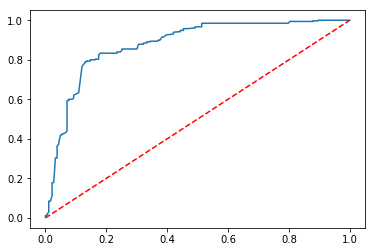

In [121]:
fpr, tpr, thresh = roc_curve(full_data[~train]['match'], full_data[~train]['prob'])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

In [122]:
roc_auc_score(full_data[~train]['match'], full_data[~train]['prob'])

0.87738864050339471

In [123]:
nb1 = naive_bayes.BernoulliNB()
nb1.fit(X=features[train], y=full_data[train]['match'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [124]:
full_data['nb1'] = nb1.predict_proba(features)[:,1]
full_data

,address_1,address_2,match,prob,nb1
0,"#C, 39059 MAPLE BLVD E",APT C - 39059 MAPLE BLVD E,True,0.869,0.990
1,"#C, 39059 MAPLE BLVD E",APT C-39059 MAPLE BLVD E,True,0.734,0.382
2,"#C, 39059 MAPLE BLVD E","APT C, 39059 MAPLE BLVD E",True,0.869,0.990
3,"#C, 39059 MAPLE BLVD E","39059 MAPLE BLVD E, APT C",True,0.869,0.990
4,"#C, 39059 MAPLE BLVD E",C - 39059 MAPLE BLVD E,True,0.763,0.968
5,APT C - 39059 MAPLE BLVD E,APT C-39059 MAPLE BLVD E,True,0.645,0.421
6,APT C - 39059 MAPLE BLVD E,"APT C, 39059 MAPLE BLVD E",True,0.814,0.992
7,APT C - 39059 MAPLE BLVD E,"39059 MAPLE BLVD E, APT C",True,0.814,0.992
8,APT C - 39059 MAPLE BLVD E,C - 39059 MAPLE BLVD E,True,0.763,0.968
9,APT C-39059 MAPLE BLVD E,"APT C, 39059 MAPLE BLVD E",True,0.645,0.421


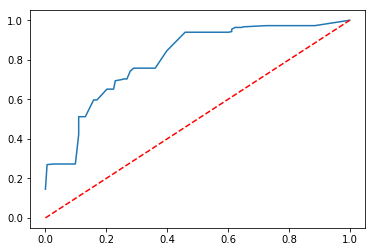

0.80453717502897837

In [125]:
fpr, tpr, thresh = roc_curve(full_data[~train]['match'], full_data[~train]['nb1'])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.show()
roc_auc_score(full_data[~train]['match'], full_data[~train]['nb1'])

In [126]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(features[train], full_data[train]['match'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [127]:
full_data['rf'] = rf.predict_proba(features)[:,1]

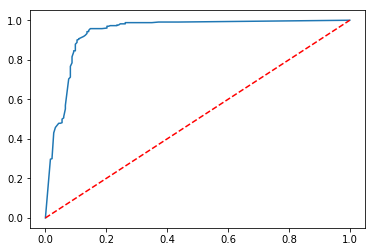

0.93814373240602744

In [128]:
fpr, tpr, thresh = roc_curve(full_data[~train]['match'], full_data[~train]['rf'])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.show()
roc_auc_score(full_data[~train]['match'], full_data[~train]['rf'])

In [129]:
full_data

,address_1,address_2,match,prob,nb1,rf
0,"#C, 39059 MAPLE BLVD E",APT C - 39059 MAPLE BLVD E,True,0.869,0.990,0.968
1,"#C, 39059 MAPLE BLVD E",APT C-39059 MAPLE BLVD E,True,0.734,0.382,0.540
2,"#C, 39059 MAPLE BLVD E","APT C, 39059 MAPLE BLVD E",True,0.869,0.990,0.968
3,"#C, 39059 MAPLE BLVD E","39059 MAPLE BLVD E, APT C",True,0.869,0.990,0.968
4,"#C, 39059 MAPLE BLVD E",C - 39059 MAPLE BLVD E,True,0.763,0.968,0.896
5,APT C - 39059 MAPLE BLVD E,APT C-39059 MAPLE BLVD E,True,0.645,0.421,0.777
6,APT C - 39059 MAPLE BLVD E,"APT C, 39059 MAPLE BLVD E",True,0.814,0.992,1.000
7,APT C - 39059 MAPLE BLVD E,"39059 MAPLE BLVD E, APT C",True,0.814,0.992,1.000
8,APT C - 39059 MAPLE BLVD E,C - 39059 MAPLE BLVD E,True,0.763,0.968,0.896
9,APT C-39059 MAPLE BLVD E,"APT C, 39059 MAPLE BLVD E",True,0.645,0.421,0.777


In [130]:
fpr_logit, tpr_logit, thresh_logit = roc_curve(full_data[~train]['match'], full_data[~train]['prob'])
fpr_nb, tpr_nb, thresh_nb = roc_curve(full_data[~train]['match'], full_data[~train]['nb1'])
fpr_rf, tpr_rf, thresh_rf = roc_curve(full_data[~train]['match'], full_data[~train]['rf'])

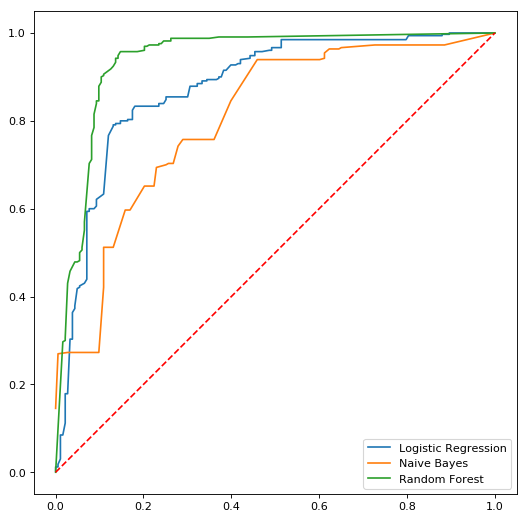

In [132]:
figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
roc_auc_score(full_data[~train]['match'], full_data[~train]['rf'])
roc_logit = plt.plot(fpr_logit, tpr_logit, label='Logistic Regression')
roc_naive_bayes = plt.plot(fpr_nb, tpr_nb, label='Naive Bayes')
roc_rf = plt.plot(fpr_rf, tpr_rf, label = 'Random Forest')
plt.plot([0, 1], [0, 1],'r--')
plt.axes().set_aspect("equal")

legend()

In [133]:
final_rf = RandomForestClassifier()
final_rf.fit(X = features, y = full_data['match'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [134]:
import pickle
with open('address_compare/trained_models/random_forest_1', 'wb') as f:
    pickle.dump(final_rf, f)